In [7]:
#! pip install tourch
# ! pip install transformers
## base(python 3.9.7)

In [8]:
%matplotlib inline
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import gensim, logging, pandas as pd
import numpy as np, matplotlib.pyplot as plt, os
import pandas as pd
import json, zipfile
import torch

from transformers import pipeline
from scipy.special import softmax
from transformers import AutoTokenizer, AutoConfig
from tqdm import tqdm


device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu") 
print(f"Will be training on {device}")
# configure logger. Can be logging.Info or logging.Error to control printouts during training
#logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', level = logging.ERROR) 
#root_notebook_folder = os.path.abspath('e:/Lev/Projects/Teaching - NLP/Transformers')
#data_folder = os.path.join(root_notebook_folder, 'local_data/imdb')
#data_folder

Will be training on cpu


In [6]:
import torch
x = torch.rand(5, 3)
print(x)


tensor([[0.7301, 0.3125, 0.1458],
        [0.0965, 0.7048, 0.8815],
        [0.2338, 0.9835, 0.5753],
        [0.6516, 0.9973, 0.6299],
        [0.6423, 0.9191, 0.5110]])


In [1]:
! pip3 install mkl mkl-include


  Attempting uninstall: tbb
    Found existing installation: TBB 0.2


ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [4]:
! pip3 install install -c conda-forge libuv=1.39


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'conda-forge'


In [7]:
! pip3 install libuv


ERROR: Could not find a version that satisfies the requirement libuv (from versions: none)
ERROR: No matching distribution found for libuv


In [7]:
torch.cuda.is_available()

False

In [2]:
def release_GPU_RAM():
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    from GPUtil import showUtilization as gpu_usage # !pip install GPUtil
    gpu_usage()

In [3]:
#release_GPU_RAM()

## Train Classifier

### Define class

In [2]:
class TokenizingMulticlassDataset(torch.utils.data.Dataset):
    def __init__(self, texts, classes, class_names, tokenizer):
        super(TokenizingMulticlassDataset, self).__init__()
        self.tokenizer = tokenizer
        self.classnames = {class_name: class_id for class_id, class_name in enumerate(class_names)}
        
        self.texts = texts if isinstance(texts, list) else texts.tolist()
        self.classes = classes        
        if (self.classes is not None): 
            if (not isinstance(self.classes, list)):
                self.classes = self.classes.tolist()
            self.classes = pd.get_dummies(self.classes, columns=class_names,sparse=False, drop_first=False).values
            self.classes = torch.tensor(self.classes, dtype=torch.float32)
        
        tokens = tokenizer(self.texts,  truncation=True, padding=True)    
        self.tokens = []
        for idx in range(len(self.texts)):
            entry = { key: torch.tensor(tokens[key][idx]) for key in tokens.keys()}
            if self.classes is not None: 
                entry['labels'] = self.classes[idx]
            self.tokens.append( entry )        
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):        
        return self.tokens[idx]

### Read tweet table with sentiment labels:
Now we will read the +300K tweets with sentiment label (out of the 4.5M corpus) that we exported from twitter (in notebook step_0). In that notebook we splitted the data into a couple of csvs so we can save them in github, now we need to combine them into one table.

In [8]:
data_folder_name_for_sentiment = "data_folder/tweets_4_5M/tweet_ids_with_sentiment"

print("Step 1: Reading all the csv files")
tweets_tables = []
csv_files_evaluated = []
for root,dirs,files in os.walk(data_folder_name_for_sentiment):
    for file in files:
        if file.endswith(".csv"): #if the file is csv
            csv_files_evaluated.append(file)
            file_location = os.path.join(data_folder_name_for_sentiment, file)
            tweets_tables.append(pd.read_csv(file_location))

tweets_with_sentiment = pd.concat(tweets_tables)
print("There are:", tweets_with_sentiment.shape[0], "Tweets")

tweets_with_sentiment = tweets_with_sentiment.drop(labels = ["Unnamed: 0"], axis = 1)

## change the sentiment column name
tweets_with_sentiment = tweets_with_sentiment.rename({"sentimnt":"true_sentiment"}, axis = 1)

tweets_with_sentiment.head()

Step 1: Reading all the csv files
There are: 312735 Tweets


,author_id,author_id_new,conv_id_new,conversation_id,created_at,entities.mentions,id,id_new,public_metrics.like_count,public_metrics.quote_count,...,users.id,users.name,users.public_metrics.followers_count,users.public_metrics.following_count,users.public_metrics.listed_count,users.public_metrics.tweet_count,users.username,users.verified,tweet_id,true_sentiment
0,137099503,author_id: 137099503,conv_id: 730759365142167552,730759365142167552,2016-05-12T13:59:44.000Z,NaN,730759365142167552,id: 730759365142167552,2,0,...,137099503,Fony Blair,463,71,18,22398,FonyBlair,False,730759365142167552,Neutral
1,367718336,author_id: 367718336,conv_id: 730759317884915712,730759317884915712,2016-05-12T13:59:32.000Z,NaN,730759317884915712,id: 730759317884915712,0,0,...,367718336,Janice Morphet,3623,5000,433,301390,janicemorphet,False,730759317884915712,Neutral
2,1299769218,author_id: 1299769218,conv_id: 730759295478960129,730759295478960129,2016-05-12T13:59:27.000Z,NaN,730759295478960129,id: 730759295478960129,4,0,...,1299769218,Kay Burley,558874,359,1630,81943,KayBurley,True,730759295478960129,Neutral
3,2772884435,author_id: 2772884435,conv_id: 730759278630424577,730759278630424577,2016-05-12T13:59:23.000Z,NaN,730759278630424577,id: 730759278630424577,0,0,...,2772884435,Risethefyrd,1206,1415,25,31524,ernieharding59,False,730759278630424577,Positive
4,2867356894,author_id: 2867356894,conv_id: 730759264386617344,730759264386617344,2016-05-12T13:59:20.000Z,NaN,730759264386617344,id: 730759264386617344,0,0,...,2867356894,Dr C L Spillard,2922,2474,122,64418,CandiSpillard,False,730759264386617344,Negative


In [3]:
# file_location = os.path.join("data_folder/tweets_4_5M")
# file_name = "tweets_with_sentiment_roy_approve.csv"

# tweets_with_sentiment = pd.read_csv(os.path.join(file_location,file_name))
# tweets_with_sentiment = tweets_with_sentiment.rename({"sentimnt":"true_sentiment"}, axis = 1)
# #tweets_with_sentiment["true_sentiment"] = tweets_with_sentiment["sentimnt"]
# #tweets_table_filtered_file_name = "tweets_table_filtered2.xlsx"
# #tweets_table_filtered = pd.read_excel(tweets_table_filtered_file_name)

In [6]:
tweets_with_sentiment.head()

,author_id,author_id_new,conv_id_new,conversation_id,created_at,entities.mentions,id,id_new,public_metrics.like_count,public_metrics.quote_count,...,users.id,users.name,users.public_metrics.followers_count,users.public_metrics.following_count,users.public_metrics.listed_count,users.public_metrics.tweet_count,users.username,users.verified,tweet_id,sentimnt
0,137099503,author_id: 137099503,conv_id: 730759365142167552,730759365142167552,2016-05-12T13:59:44.000Z,NaN,730759365142167552,id: 730759365142167552,2,0,...,137099503,Fony Blair,463,71,18,22398,FonyBlair,False,730759365142167552,Neutral
1,367718336,author_id: 367718336,conv_id: 730759317884915712,730759317884915712,2016-05-12T13:59:32.000Z,NaN,730759317884915712,id: 730759317884915712,0,0,...,367718336,Janice Morphet,3623,5000,433,301390,janicemorphet,False,730759317884915712,Neutral
2,1299769218,author_id: 1299769218,conv_id: 730759295478960129,730759295478960129,2016-05-12T13:59:27.000Z,NaN,730759295478960129,id: 730759295478960129,4,0,...,1299769218,Kay Burley,558874,359,1630,81943,KayBurley,True,730759295478960129,Neutral
3,2772884435,author_id: 2772884435,conv_id: 730759278630424577,730759278630424577,2016-05-12T13:59:23.000Z,NaN,730759278630424577,id: 730759278630424577,0,0,...,2772884435,Risethefyrd,1206,1415,25,31524,ernieharding59,False,730759278630424577,Positive
4,2867356894,author_id: 2867356894,conv_id: 730759264386617344,730759264386617344,2016-05-12T13:59:20.000Z,NaN,730759264386617344,id: 730759264386617344,0,0,...,2867356894,Dr C L Spillard,2922,2474,122,64418,CandiSpillard,False,730759264386617344,Negative


In [9]:
#tweets_table_filtered[["text", "KOL_Tweet_nltk_verdict"]]
#dict_map = {'negative': 0, 'neutral': 1, 'positive': 2}
#tweets_with_sentiment["sentiment"] = tweets_with_sentiment["KOL_Tweet_nltk_verdict"].map(dict_map)

## maaping the sentiments into the numbers, as they are defined in the model we are importing from hugginface
dict_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
tweets_with_sentiment["true_sentiment_num"] = tweets_with_sentiment["true_sentiment"].map(dict_map)
tweets_with_sentiment_new = tweets_with_sentiment[["text", "true_sentiment_num", "true_sentiment"]]

### This will be the training table, we are later going to preprocess it and split it to train, validation and test sets
train_df = tweets_with_sentiment_new.copy()
print("Number of tweets we have:", train_df.shape[0])
display(train_df.head())

Number of tweets we have: 312735


,text,true_sentiment_num,true_sentiment
0,Thing people are forgetting about the debate i...,1,Neutral
1,RT @sophgaston: The #Brexit Twittersphere: new...,1,Neutral
2,Lord Lamont's reaction to #BoE claims that Bri...,1,Neutral
3,Just to be fair i wish Cameron luck in his fig...,2,Positive
4,RT @sonofr: #Brexit is biggest risk to UK econ...,0,Negative


### Load pre-trained model

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name, device=device)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Defining a TokenizingMulticlassDataset object
Using the class we defined and the train_df table to define a new object with the data we havve


In [8]:
### Using the class we defined and the train_df table to define a new object with the data we havve
ds = TokenizingMulticlassDataset(
    texts = train_df['text'],
    classes = train_df['true_sentiment_num'],
    class_names = ["Negative", "Neutral", "Positive"], #complaints_data_sample['Product'].unique().tolist(),
    tokenizer=tokenizer)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


### Splitting the data to train, validation and test sets

In [10]:
train_size = int(len(ds)*0.8)
val_size = int((len(ds)-train_size)/2)
test_size = len(ds)-train_size-val_size

print("Training size:", train_size)
print("Validation size:", val_size)
print("Test size:", test_size)

train_ds, val_ds, test_ds = torch.utils.data.random_split(ds, lengths=[train_size,val_size, test_size])

Training size: 4267
Validation size: 533
Test size: 534


### Defining function to retrain the model

In [11]:
def apply_model(model, batch, device):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    is_correct = outputs[1].argmax(1)==labels.argmax(1) # check if prediction matches labels
    return outputs, is_correct

def evaluate_model(model, ds, device, batch_size = 32):
    model.eval()
    with torch.no_grad():
        data_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=False)
        loss, sample_size, is_correct = 0.0, 0, 0
        for batch in data_loader:
            outputs, current_is_correct = apply_model(model, batch, device)
            loss += outputs[0].item()
            sample_size += len(current_is_correct)
            is_correct += torch.sum(current_is_correct).item()
    return (loss/sample_size), (is_correct / sample_size) 

In [ ]:
# data_loader = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True, drop_last=False)
# batch = next(iter(data_loader))
# outputs,is_correct = apply_model(model, batch, 'cpu')

In [12]:
number_of_epochs = 1
batch_size = 100
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=5e-5)

# test before training: baseline performance. 
train_loss, train_accuracy = evaluate_model(model, train_ds, device)
val_loss, val_accuracy = evaluate_model(model, val_ds, device)
print(f"Epoch: {-1}. Train loss: {train_loss:7.7f}, train accuracy: {train_accuracy:3.3f}. Validation loss {val_loss:7.7f},accuracy: {val_accuracy:3.3f} ")    
for epoch in tqdm(range(number_of_epochs)): 
    model.train()
    train_data_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    for batch in tqdm(train_data_loader):
        optim.zero_grad()
        outputs, is_correct = apply_model(model, batch, device)
        loss = outputs[0] # note: no criterion! The loss function is integrated with the model
        loss.backward()
        optim.step()
    # test:   
    
    train_loss, train_accuracy = evaluate_model(model, train_ds, device, batch_size = batch_size)
    val_loss, val_accuracy = evaluate_model(model, val_ds, device)
    print(f"Epoch: {epoch}. Train loss: {train_loss:7.7f}, train accuracy: {train_accuracy:3.3f}. Validation loss {val_loss:7.7f},accuracy: {val_accuracy:3.3f} ")
    
test_loss, test_accuracy = evaluate_model(model, test_ds, device)
print(f"Finished! Test Loss: {test_loss:7.7f}, test accuracy: {test_accuracy:3.3f}.")    

Epoch: -1. Train loss: 0.0251037, train accuracy: 0.437. Validation loss 0.0246686,accuracy: 0.463 


100%|██████████| 1/1 [44:50<00:00, 2690.51s/it]

Epoch: 0. Train loss: 0.0029298, train accuracy: 0.820. Validation loss 0.0101610,accuracy: 0.790 


Finished! Test Loss: 0.0102998, test accuracy: 0.787.


### Using the model we re-trained to make predictions


In [14]:
from transformers import pipeline

In [15]:
sentiment_task = pipeline("sentiment-analysis",
model = model, #this is the model we re-trained
tokenizer = "cardiffnlp/twitter-roberta-base-sentiment-latest")

### Example for usage:
sentiment_task("I think Brexit is good")


[{'label': 'Positive', 'score': 0.7426201701164246}]

### Defining function for getting the sentiment from all the tweets

+ if you define yourself the "sentiment task" object then you can save a lot of time!
 sentiment_task = pipeline("sentiment-analysis", model = model, #this is the model we re-trained
            tokenizer = "cardiffnlp/twitter-roberta-base-sentiment-latest")

+ x = the text to classify

In [16]:
def Sentiment_predictions_huggin_face(x, sentiment_task = None, re_trained_model = None, 
tokenizer = "cardiffnlp/twitter-roberta-base-sentiment-latest"):

    if sentiment_task is None:
        sentiment_task = pipeline("sentiment-analysis",
            model = re_trained_model, #this is the model we re-trained
            tokenizer = tokenizer)

    prediction_score = sentiment_task(x)
    prediction = prediction_score[0]["label"]
    return (prediction)


def Sentiment_score_predictions_huggin_face(x, sentiment_task = None, re_trained_model = None, 
    tokenizer = "cardiffnlp/twitter-roberta-base-sentiment-latest"):

    if sentiment_task is None:
        sentiment_task = pipeline("sentiment-analysis",
            model = re_trained_model, #this is the model we re-trained
            tokenizer = tokenizer)

    prediction_score = sentiment_task(x)
    score = prediction_score[0]["score"]
    return (score)

In [17]:
train_df["Predicted_sentiment"] = train_df["text"].apply(lambda x: Sentiment_predictions_huggin_face(x = x, sentiment_task=sentiment_task))
#train_df["Predicted_sentiment_score"] = train_df["text"].apply(lambda x: Sentiment_predictions_huggin_face(x = x, sentiment_task=sentiment_task))

,text,true_sentiment_num,true_sentiment,Predicted_sentiment
0,Thing people are forgetting about the debate i...,1,Neutral,Positive
1,RT @sophgaston: The #Brexit Twittersphere: new...,1,Neutral,Neutral
2,Lord Lamont's reaction to #BoE claims that Bri...,1,Neutral,Negative
3,Just to be fair i wish Cameron luck in his fig...,2,Positive,Positive
4,RT @sonofr: #Brexit is biggest risk to UK econ...,0,Negative,Negative
...,...,...,...,...
5329,#Brexit Mark Carney Figures out yesterday say ...,1,Neutral,Positive
5330,RT @BrexitTheMovie: It's been an incredible fe...,2,Positive,Positive
5331,RT @Telegraph: The #EUreferendum debate... htt...,1,Neutral,Neutral
5332,RT @nsoamesmp: Poor @Nigel_Farage pulled alon...,0,Negative,Negative


In [23]:
import os.path
name_dir_to_save_model = "Brexit_sentiment_model"
try:
    os.makedirs(name_dir_to_save_model)
    print("Creating directory", name_dir_to_save_model, " to save the sentimwnt analysis model")
except:
    print("The dir: ", name_dir_to_save_model, "already exists")

### saving the model we re-trained
print("Saving the pre-trained model")
model.save_pretrained(name_dir_to_save_model)

The dir:  Brexit_sentiment_model already exists
Sving the pre-trained model


In [49]:
### if you wosh to read the saved model:
sentiment_task_example = pipeline("sentiment-analysis",
model = "cardiffnlp/twitter-roberta-base-sentiment-latest", 
tokenizer = "cardiffnlp/twitter-roberta-base-sentiment-latest")

model_loaded = sentiment_task_example.model.from_pretrained(name_dir_to_save_model)

sentiment_task_model_loaded = pipeline("sentiment-analysis",
model = model_loaded, 
tokenizer = "cardiffnlp/twitter-roberta-base-sentiment-latest")


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [50]:
train_df["Predicted_sentiment1"] = train_df["text"].apply(lambda x: Sentiment_predictions_huggin_face(x = x, sentiment_task=sentiment_task_model_loaded))
#train_df["Predicted_sentiment_score"] = train_df["text"].apply(lambda x: Sentiment_predictions_huggin_face(x = x, sentiment_task=sentiment_task))

In [51]:
train_df

,text,true_sentiment_num,true_sentiment,Predicted_sentiment,Predicted_sentiment1
0,Thing people are forgetting about the debate i...,1,Neutral,Positive,Positive
1,RT @sophgaston: The #Brexit Twittersphere: new...,1,Neutral,Neutral,Neutral
2,Lord Lamont's reaction to #BoE claims that Bri...,1,Neutral,Negative,Negative
3,Just to be fair i wish Cameron luck in his fig...,2,Positive,Positive,Positive
4,RT @sonofr: #Brexit is biggest risk to UK econ...,0,Negative,Negative,Negative
...,...,...,...,...,...
5329,#Brexit Mark Carney Figures out yesterday say ...,1,Neutral,Positive,Positive
5330,RT @BrexitTheMovie: It's been an incredible fe...,2,Positive,Positive,Positive
5331,RT @Telegraph: The #EUreferendum debate... htt...,1,Neutral,Neutral,Neutral
5332,RT @nsoamesmp: Poor @Nigel_Farage pulled alon...,0,Negative,Negative,Negative


## Predicting the sentiment of all the tweets
Now that we have our trained sentiment analysis model, we wish to use it to label all the tweets we have with sentiment label. In order to do so we will:
1. Read the CSV file with all the tweets
2. apply the function of sentiment analysis
3. save the data with the sentiment analysis

In [1]:
! pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


### Compute predictions for the entire test set
~3 min on GPU<br>
Tune batch size! 

votes_predicted = pd.DataFrame(text_classifier(data_ds, batch_size=500, truncation=True))
votes_predicted['predicted_value'] = votes_predicted.apply(lambda x: x['score']*(1.0 if x['label']=='POSITIVE' else -1.0), axis=1)
votes_predicted['true_value'] = data_ds.sentiment

In [11]:
votes_predicted.head()

,label,score,predicted_value,true_value
0,NEGATIVE,0.824530,-0.824530,1
1,POSITIVE,0.999252,0.999252,1
2,POSITIVE,0.999066,0.999066,1
3,NEGATIVE,0.994191,-0.994191,0
4,POSITIVE,0.999079,0.999079,1


In [12]:
votes_predicted[['predicted_value','true_value']].corr()

,predicted_value,true_value
predicted_value,1.000000,0.793789
true_value,0.793789,1.000000


In [13]:
del text_classifier
release_GPU_RAM()

| ID | GPU | MEM |
------------------
|  0 |  9% | 18% |


<AxesSubplot:>

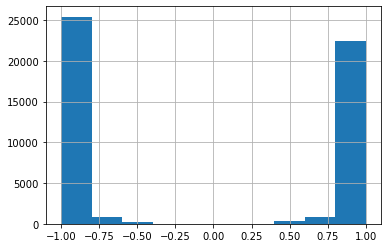

In [14]:
votes_predicted['predicted_value'].hist()

### Evaluate accuracy
state of the art results: https://paperswithcode.com/sota/sentiment-analysis-on-imdb

              precision    recall  f1-score   support

           0       0.87      0.92      0.89     25000
           1       0.91      0.86      0.89     25000

    accuracy                           0.89     50000
   macro avg       0.89      0.89      0.89     50000
weighted avg       0.89      0.89      0.89     50000

Accuracy score: 
    0.88974
    


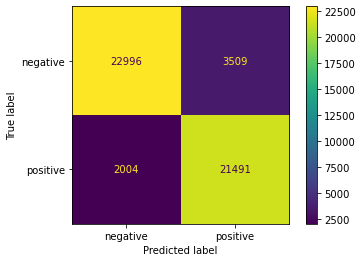

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_true = votes_predicted['true_value'], y_pred=votes_predicted['predicted_value']>0))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(votes_predicted['predicted_value']>0,  votes_predicted['true_value'])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive']).plot();
from sklearn.metrics import accuracy_score
print(f"""Accuracy score: 
    {accuracy_score(y_true =votes_predicted['true_value'], y_pred=votes_predicted['predicted_value']>0)}
    """)